In [4]:
import flax
import jax
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
from tensorflow import keras as K

# Sample data

2024-04-14 02:04:05.630164: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(2, 28, 28, 1)

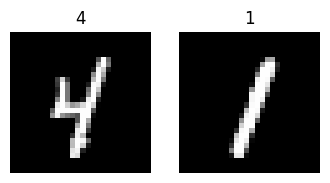

In [5]:
image_rescaling = K.layers.Rescaling(scale=1.0 / 127.5, offset=-1)

(sample,) = tfds.load("mnist", split=["train[:2]"])
sample = sample.map(
    lambda x: {"image": image_rescaling(x["image"]), "label": x["label"]}
)

fig, axes = plt.subplots(1, 2, figsize=(4, 6))
for ax, x in zip(axes.flatten(), (x for x in sample.as_numpy_iterator())):
    # d = next(sample_iter)
    ax.imshow(x["image"], cmap="gray")
    ax.axis("off")
    ax.set_title(x["label"])

X = np.array([x["image"] for x in sample.as_numpy_iterator()])
X.shape

# U-Net

In [6]:
from typing import Any, Callable, Optional, Sequence

from flax import linen as nn
from flax.linen.module import compact
from jax import numpy as jnp

In [7]:
rng_root = jax.random.PRNGKey(0)
rng_keys = ["noise", "dropout"]
(rng,) = jax.random.split(rng_root, 1)


def update_rngs(rng: jax.random.PRNGKey, rng_keys):
    rng, *rngs = jax.random.split(rng, len(rng_keys) + 1)
    rngs = {k: rngs[i] for i, k in enumerate(rng_keys)}

    return rng, rngs


rng, rngs = update_rngs(rng, rng_keys)

In [8]:
class ConvBlock(nn.Module):
    features: int
    kernel_size: [int, int] = (3, 3)

    @compact
    def __call__(self, x: jax.Array, train: bool = False):
        return nn.Sequential(
            [
                nn.Conv(self.features, kernel_size=self.kernel_size),
                nn.relu,
                nn.Conv(self.features, kernel_size=self.kernel_size),
                nn.relu,
                nn.BatchNorm(use_running_average=not train),
            ]
        )(x)


model = ConvBlock(5)
variables = model.init(rng, jnp.empty_like(X))
y = model.apply(variables, X)
y.shape

(2, 28, 28, 5)

In [9]:
class LearnedTimeEmbed(nn.Module):
    L: int
    d_model: int

    dtype: Any = jnp.float32

    @compact
    def __call__(self, t: Sequence[int]):
        embeds = nn.Embed(self.L, self.d_model)(jnp.array(t))

        return embeds[:, None, None, ...]


model = LearnedTimeEmbed(100, 5)
variables = model.init(rng, t=[0])
y = model.apply(variables, t=[0, 1])
y.shape

(2, 1, 1, 5)

In [10]:
class UNet(nn.Module):
    """
    A simple u-net
    """

    T: int  # total time step number
    kernel_size: [int, int] = (3, 3)
    strides: [int, int] = (2, 2)

    dtype: Any = jnp.float32

    @compact
    def __call__(
        self, x: jax.Array, t: Sequence[int], train: bool = False
    ) -> jax.Array:
        assert len(x.shape) == 4
        assert len(t) == x.shape[0]

        time_embeds = LearnedTimeEmbed(self.T, 64)

        # encoder
        skip0 = ConvBlock(32, self.kernel_size)(x, train)
        down0 = nn.max_pool(skip0, window_shape=(2, 2), strides=(2, 2))

        skip1 = ConvBlock(64, self.kernel_size)(down0, train)
        down1 = nn.max_pool(skip1, window_shape=(2, 2), strides=(2, 2))

        # decoder
        up1 = nn.ConvTranspose(64, kernel_size=(2, 2), strides=(2, 2))(down1)
        up1 = up1 + nn.relu(
            nn.Dense(up1.shape[-1])(time_embeds(t))
        )  # add time embedding
        assert up1.shape[:-1] == skip1.shape[:-1]
        up1 = jnp.concatenate([up1, skip1], axis=-1)  # add skip
        up1 = ConvBlock(64, self.kernel_size)(up1, train)

        up0 = nn.ConvTranspose(32, kernel_size=(2, 2), strides=(2, 2))(up1)
        up0 = up0 + nn.relu(nn.Dense(up0.shape[-1])(time_embeds(t)))
        up0 = jnp.concatenate([up0, skip0], axis=-1)
        up0 = ConvBlock(32, self.kernel_size)(up0, train)

        z = nn.Conv(x.shape[-1], kernel_size=(1, 1))(up0)

        z = nn.relu(z)
        z = nn.BatchNorm(use_running_average=not train)(z)

        return z

(2, 28, 28, 1)


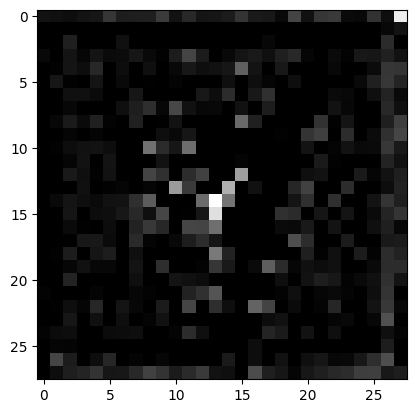

In [27]:
unet = UNet(100)
unet_var = unet.init(rng, X, [0, 0])
y, _ = unet.apply(unet_var, X, [1, 2], train=True, mutable=["batch_stats"])

print(y.shape)
plt.imshow(y[0], cmap="gray")

In [22]:
print(unet.tabulate({"params": rng, **rngs}, X, [0] * X.shape[0]))


                                  UNet Summary                                  
┏━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ path       ┃ module     ┃ inputs     ┃ outputs    ┃ params     ┃ batch_stats ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│            │ UNet       │ -          │ float32[2… │            │             │
│            │            │ float32[2… │            │            │             │
│            │            │ - - 0      │            │            │             │
│            │            │   - 0      │            │            │             │
├────────────┼────────────┼────────────┼────────────┼────────────┼─────────────┤
│ ConvBlock… │ ConvBlock  │ -          │ float32[2… │            │             │
│            │            │ float32[2… │            │            │             │
│            │            │ - False    │            │            │             │
├────────────┼────────────┼

# Diffusion Model

In [13]:
class DiffusionModel:
    total_steps: int = 50

    dtype: Any = jnp.float32

    def __init__(self, total_steps: int):
        self.total_steps = total_steps
        self.betas = jnp.linspace(0.0001, 0.02, self.total_steps)
        self.alphas = 1.0 - self.betas
        self.alphas_bar = jnp.cumprod(self.alphas, axis=0, dtype=self.dtype)

    def __call__(self, x: jax.Array, t: Sequence[int], rng: jax.Array):
        return self.add_noise(x, t, rng)

    def add_noise(self, x: jax.Array, t: Sequence[int], rng: jax.Array):
        assert x.shape[0] == len(t), "batch size mismatch"
        alphas_bar_t = self.alphas_bar[t,].reshape((-1, 1, 1, 1))
        mean = jnp.sqrt(alphas_bar_t) * x
        noise = jax.random.normal(rng, x.shape)
        variance = jnp.sqrt(1.0 - alphas_bar_t) * noise

        x_t = mean + variance

        return x_t, noise

    def ddpm(self, x: jax.Array, noise: jax.Array, t: int, rng: jax.Array):
        B, *_ = x.shape
        betas_t = self.betas.take(t)
        alphas_t = self.alphas.take(t)
        alphas_bar_t = self.alphas_bar.take(t)
        one_alphas_t = 1.0 - alphas_t
        sqrt_one_alphas_bar_t = jnp.sqrt(1.0 - alphas_bar_t)

        mean = (x - (one_alphas_t / sqrt_one_alphas_bar_t) * noise) / jnp.sqrt(alphas_t)

        if t > 0:
            return mean + jnp.sqrt(betas_t) * jax.random.normal(rng, x.shape)
        else:
            return mean

    def ddim(self, x_t: jax.Array, t: int, t_p: int, noise: jax.Array):
        ab_t = self.alphas_bar.take(t).reshape((-1, 1, 1, 1))
        ab_p = self.alphas_bar.take(t_p).reshape((-1, 1, 1, 1))

        x_0_ = jnp.sqrt(ab_p / ab_t) * (x_t - jnp.sqrt(1.0 - ab_t) * noise)
        dir_x_t = jnp.sqrt(1.0 - ab_p) * noise

        return x_0_ + dir_x_t

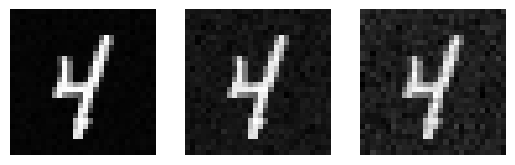

In [20]:
dm = DiffusionModel(total_steps=500)
x_t, noise = dm(jnp.stack([X[0]] * 3, axis=0), [1, 10, 20], rng)

fig, axes = plt.subplots(1, 3)
for x, ax in zip(x_t, axes.flatten()):
    ax.imshow(x, cmap="gray")
    ax.axis("off")

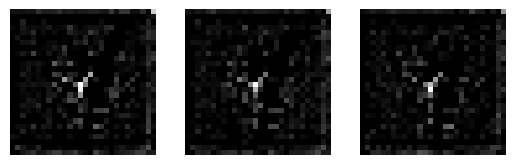

In [28]:
pred, _ = unet.apply(unet_var, x_t, [1, 10, 20], train=True, mutable=["batch_stats"])
fig, axes = plt.subplots(1, 3)
for x, ax in zip(pred, axes):
    ax.imshow(x, cmap="gray")
    ax.axis("off")

In [30]:
output = dm.ddpm(x_t, pred, 498, rng=rng)
# output = dm.ddim(x_t, 5, 15, noise)

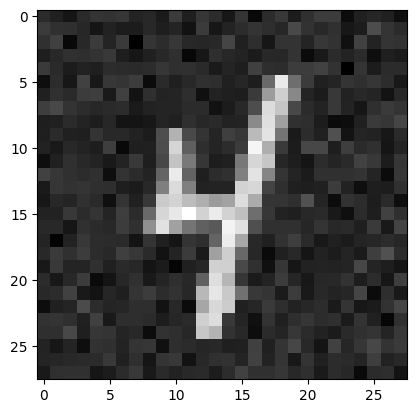

In [31]:
plt.imshow(output[0], cmap="gray")

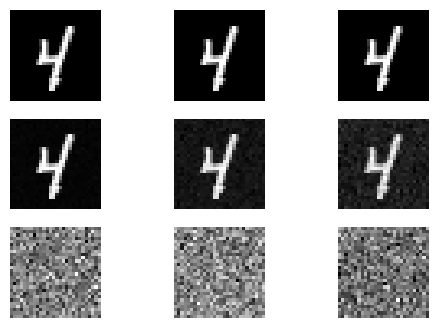

In [33]:
fig, axes = plt.subplots(3, 3, figsize=(6, 4))

images = [[X[0]] * 3, x_t, noise]
for i, i_axes in enumerate(axes):
    for j, ax in enumerate(i_axes):
        ax.axis("off")
        ax.imshow(images[i][j], cmap="gray")

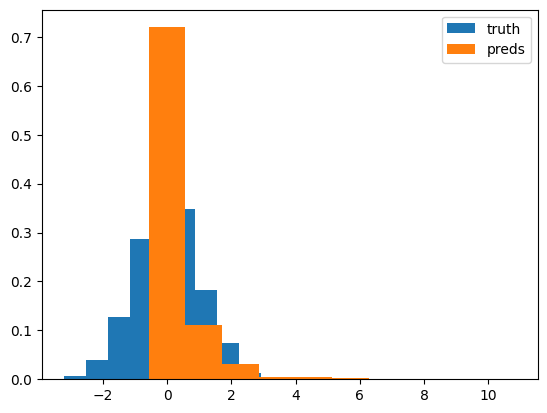

In [29]:
plt.hist(noise.flatten(), density=True, label="truth")
plt.hist(pred.flatten(), density=True, label="preds")
plt.legend()
plt.show()

# Training

In [39]:
import os
from datetime import datetime
from functools import partial

import optax  # Common loss functions and optimizers
import orbax.checkpoint as ocp
from clu import metrics
from flax import struct  # Flax dataclasses
from flax.metrics import tensorboard
from flax.training import train_state # Useful dataclass to keep train state

# from orbax.checkpoint import Checkpointer, JsonCheckpointHandler, PyTreeCheckpointer
# from tqdm.notebook import tqdm

In [40]:
@struct.dataclass
class Metrics(metrics.Collection):
    loss: metrics.Average.from_output("loss")


class TrainState(train_state.TrainState):
    metrics: Metrics
    batch_stats: Any

In [41]:
def create_train_state(
    module: nn.Module,
    params: dict,
    batch_stats: Any,
    learning_rate: float,
    momentum: Optional[float] = None,
    weight_decay: Optional[float] = None,
    warmup_steps: Optional[int] = None,
    max_steps: Optional[int] = None,
):
    """Creates an initial `TrainState`."""

    # lr_scheduler = optax.warmup_cosine_decay_schedule(
    #     init_value=0.0,
    #     peak_value=learning_rate,
    #     warmup_steps=warmup_steps,
    #     decay_steps=max_steps,
    # )
    tx = optax.chain(
        optax.clip_by_global_norm(1.0),
        # optax.adamw(learning_rate, weight_decay=weight_decay)
        # optax.sgd(learning_rate=learning_rate, momentum=momentum)
        optax.adam(learning_rate=learning_rate),
    )

    return TrainState.create(
        apply_fn=module.apply,
        params=params,
        batch_stats=batch_stats,
        tx=tx,
        metrics=Metrics.empty(),
    )

In [42]:
@jax.jit
def train_step(state, batch: jax.Array, noises: jax.Array, t: Sequence[int], rngs):
    """Train for a single step."""

    def loss_fn(params, noises):
        preds, updates = state.apply_fn(
            {"params": params, "batch_stats": state.batch_stats},
            x=batch,
            t=t,
            rngs=rngs,
            train=True,
            mutable=["batch_stats"],
        )
        assert preds.shape == noises.shape

        B, *_ = batch.shape
        preds = preds.reshape((B, -1))
        noises = noises.reshape((B, -1))
        loss = optax.squared_error(preds, noises).mean()

        return loss, (preds, updates)

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, (preds, updates)), grads = grad_fn(state.params, noises)
    state = state.apply_gradients(grads=grads)
    state = state.replace(batch_stats=updates["batch_stats"])
    metric_updates = state.metrics.single_from_model_output(preds=preds, loss=loss)
    metrics = state.metrics.merge(metric_updates)
    state = state.replace(metrics=metrics)

    return state, metric_updates

In [43]:
# prepare training dataset

(train_ds,) = tfds.load("mnist", split=["train"])
batch_size = 128
num_epochs = 500

num_examples = train_ds.cardinality().numpy()
image_rescaling = K.layers.Rescaling(scale=1.0 / 127.5, offset=-1)
train_ds = (
    train_ds.repeat(num_epochs)
    .shuffle(num_examples * 3)
    .map(
        lambda x: {"image": image_rescaling(x["image"]), "label": x["label"]},
        num_parallel_calls=6,
    )
    .batch(batch_size, drop_remainder=True)
    .prefetch(4)
)

max_steps = train_ds.cardinality().numpy()
print(f"max steps = {max_steps}")
steps_per_epoch = max_steps // num_epochs
print(f"steps per epoch = {steps_per_epoch}")

max steps = 234375
steps per epoch = 468


In [44]:
# init. model and state

learning_rate = 1.5e-4
momentum = 0.9
T = 500

unet = UNet(T)
dm = DiffusionModel(T)
variables = unet.init({"params": rng, **rngs}, jnp.empty((1, 28, 28, 1)), t=[0])
state = create_train_state(
    unet,
    variables["params"],
    variables["batch_stats"],
    learning_rate,
    warmup_steps=int(0.2 * max_steps),
    max_steps=max_steps,
)

In [46]:
x_t, noises = dm(X, [3, 4], rng)

_, metrics = train_step(state, x_t, noises, [3, 4], rngs=rngs)

In [47]:
train_ds_iter = train_ds.take(5).as_numpy_iterator()

In [48]:
batch = train_ds_iter.next()
batch["image"].shape
batch_image = batch["image"]

In [49]:
rng, rngs = update_rngs(rng, rng_keys)
ts = jax.random.randint(rng, (batch_image.shape[0],), 0, T)
x_t, noises = dm(batch_image, ts, rng)
state, metric_updates = train_step(state, x_t, noises, ts, rngs)
metric_updates.compute()

{'loss': Array(1.9516476, dtype=float32)}

In [50]:
model_name = "dm-241k"
model_checkpoint = datetime.now().strftime(f"{model_name}_%Y%m%d-%H%M")
checkpoint_path = f"{os.getcwd()}/checkpoint/{model_checkpoint}"
print(
    f"""model name: {model_name},
checlpoint path: {checkpoint_path}
"""
)

model name: dm-241k,
checlpoint path: /tf/notebooks/DiffusionModel/checkpoint/dm-241k_20240414-0258



In [60]:
steps_per_checkpoint = 100
train_stop_step = np.min([200_000, max_steps])
train_steps = train_stop_step - restored_step
print(f"traning epochs: ~ {train_steps // steps_per_epoch}")

rng_root = jax.random.PRNGKey(0)
rng_keys = ["noise"]
(rng,) = jax.random.split(rng_root, 1)

traning epochs: ~ 425


In [61]:
log_dir = "tb-log"

summary_writer = tf.summary.create_file_writer(f"{log_dir}/{model_checkpoint}")

In [62]:
%load_ext tensorboard

%tensorboard --logdir={log_dir} --bind_all

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [63]:
from tqdm.notebook import tqdm

with ocp.CheckpointManager(
    checkpoint_path,
    options=ocp.CheckpointManagerOptions(max_to_keep=4, create=True),
    item_handlers={
        "state": ocp.StandardCheckpointHandler(),
        "config": ocp.JsonCheckpointHandler(),
    },
) as checkpoint_manager:

    restored_step = 0
    if checkpoint_manager.latest_step():
        restored_checkpoint = checkpoint_manager.restore(
            checkpoint_manager.latest_step(),
            items={"state": state, "config": None},
        )
        state = restored_checkpoint["state"]
        restored_step = checkpoint_manager.latest_step()

    print(f"last step: {restored_step}")

    with summary_writer.as_default():
        for step, batch in tqdm(
            enumerate(train_ds.take(train_steps).as_numpy_iterator()),
            desc="training progress",
            initial=restored_step,
            total=max_steps,
        ):
            rng, rngs = update_rngs(rng, rng_keys)
            batch_image = batch["image"]

            B, *_ = batch_image.shape
            t = jax.random.randint(rng, (B,), 0, T)
            batch_image_t, noise = dm(batch_image, t, rng)
            state, metric_updates = train_step(state, batch_image_t, noise, t, rngs)
            current_step = restored_step + step

            if current_step % steps_per_checkpoint == 0:
                checkpoint_manager.save(
                    current_step,
                    args=ocp.args.Composite(
                        state=ocp.args.StandardSave(state), config=ocp.args.JsonSave({})
                    ),
                )

                for m, v in metric_updates.compute().items():
                    tf.summary.scalar(m, v, current_step)

last step: 6200


training progress:   3%|2         | 6200/234375 [00:00<?, ?it/s]

KeyboardInterrupt: 

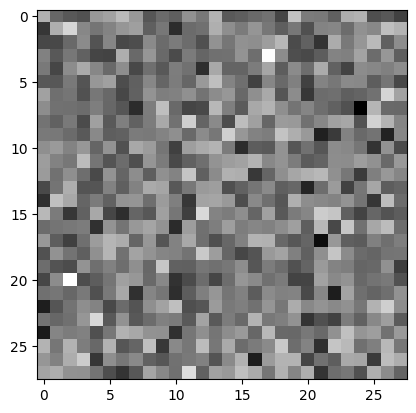

In [80]:
samples = jax.random.normal(rng, (1, 28, 28, 1))
plt.imshow(samples[0], cmap="gray")

In [81]:
%%time

denoised_images = []

for t in range(T - 1, -1, -1):
    rng, rngs = update_rngs(rng, rng_keys)
    pred_noise = unet.apply(
        {"params": state.params, "batch_stats": state.batch_stats},
        samples,
        [t],
        rngs=rngs,
    )
    samples = dm.ddpm(samples, pred_noise, t, rngs["noise"])

    if t % 20 == 0:
        denoised_images.append(samples[0])

CPU times: user 30.9 s, sys: 3.53 s, total: 34.4 s
Wall time: 30.5 s


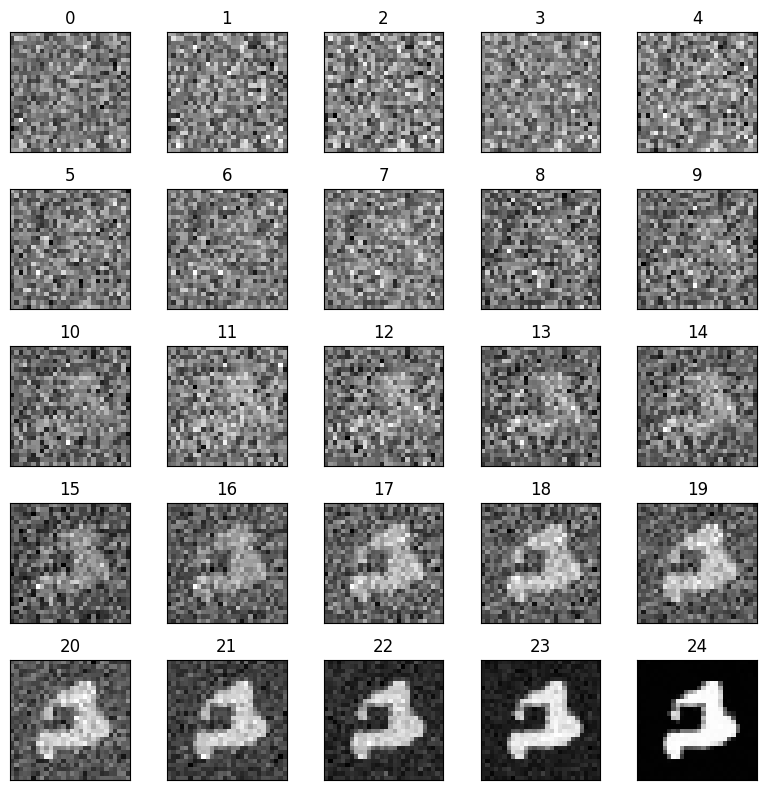

In [82]:
rows = 5
cols = 5

# Create a figure and subplots
fig, axes = plt.subplots(rows, cols, figsize=(8, 8))

# Plot each image on a separate subplot
for i in range(rows):
    for j in range(cols):
        index = i * cols + j
        axes[i, j].imshow(denoised_images[index], cmap="gray")
        axes[i, j].set_title(index)
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

# Adjust spacing and layout
fig.tight_layout()

# Display the plot
plt.show()

In [83]:
%%time

denoised_images = []
samples = jax.random.normal(rng, (30, 28, 28, 1))
step_size = 20
inference_time_steps = list(range(T - 1, 0, -step_size)) + [0]
# print(inference_time_steps)
for i, t in enumerate(inference_time_steps[:-1]):
    rng, rngs = update_rngs(rng, rng_keys)
    pred_noise = unet.apply(
        {"params": state.params, "batch_stats": state.batch_stats},
        samples,
        [t] * samples.shape[0],
        rngs=rngs,
    )

    samples = dm.ddim(samples, t, inference_time_steps[i + 1], pred_noise)
    denoised_images.append(samples)

CPU times: user 1.5 s, sys: 96.8 ms, total: 1.6 s
Wall time: 1.45 s


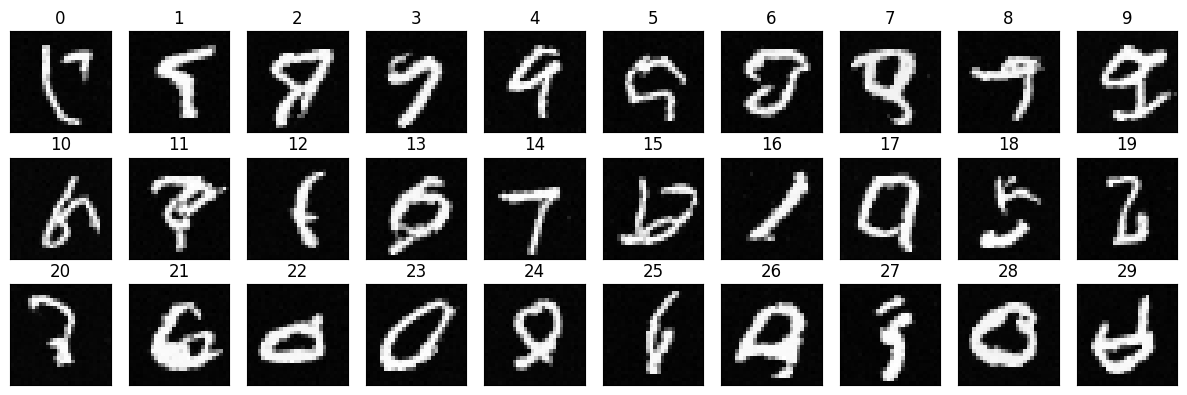

In [84]:
rows = 3
cols = 10

# Create a figure and subplots
fig, axes = plt.subplots(rows, cols, figsize=(12, 4))

# Plot each image on a separate subplot
for i in range(rows):
    for j in range(cols):
        index = i * cols + j
        axes[i, j].imshow(denoised_images[-1][index], cmap="gray")
        axes[i, j].set_title(index)
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

# Adjust spacing and layout
fig.tight_layout()

# Display the plot
plt.show()